# <div align="center"><b> Detección de palmeras mediante YoloV11 </b></div>

<div align="right">

<!-- [![Binder](http://mybinder.org/badge.svg)](https://mybinder.org/) -->
[![nbviewer](https://img.shields.io/badge/render-nbviewer-orange?logo=Jupyter)](https://nbviewer.org)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com)

</div>

* * *

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>

🛻 <em><font color='MediumSeaGreen'>  Instalaciones: </font></em> 🛻

Este notebook utiliza [Poetry](https://python-poetry.org/) para la gestión de dependencias.
Primero instala Poetry siguiendo las instrucciones de su [documentación oficial](https://python-poetry.org/docs/#installation).
Luego ejecuta el siguiente comando para instalar las dependencias necesarias y activar el entorno virtual:

- Bash:
```bash
poetry install
eval $(poetry env activate)
```

- PowerShell:
```powershell
poetry install
Invoke-Expression (poetry env activate)
```

<!-- Descargar archivos adicionales:
!gdown https://drive.google.com/drive/folders/1UBZ8PEbtmiWMGkULu7GAt3VhUpeTy9l7?usp=sharing --folder -->

In [2]:
# Chequear versión de CUDA
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Oct_30_01:18:48_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0


In [3]:
# Chequear más datos sobre la GPU
!nvidia-smi

Wed Aug  6 17:46:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
|  0%   31C    P8              6W /  320W |    1265MiB /  16376MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋

In [4]:
# Recarga automática de módulos en Jupyter Notebook
%reload_ext autoreload
%autoreload 2

import sys, json, requests, os, shutil, yaml
from pathlib import Path
from pprint import pprint

from loguru import logger as LOGGER
from modulo_ia.config import config as CONFIG
from modulo_apps.database_comunication.mongodb_client import mongodb as MONGODB

# os.environ["ALBUMENTATIONS_DISABLE"] = "1" # Deshabilita Albumentations por defecto.
import ultralytics
from ultralytics import YOLO, settings
from ultralytics.data.utils import visualize_image_annotations
import torch

import mlflow
import cv2
import PIL
from PIL import Image
import pandas as pd

import modulo_ia.dataset as DatasetProcessor
import modulo_ia.features as FeaturesProcessor
import modulo_ia.utils.gpu as GpuUtils
import modulo_ia.utils.yolo_utils as YoloUtils
from modulo_ia.modeling.predict import DetectionModelPredictor
from modulo_ia.utils.types import DatasetFormat

import modulo_apps.labeling.procesador_anotaciones_coco_dataset as CocoDatasetUtils
import modulo_apps.s3_comunication.procesador_s3 as ProcesadorS3
import modulo_apps.labeling.visualizador_coco_dataset as VisualizadorCocoDataset
import modulo_apps.labeling.procesador_anotaciones_mongodb as ProcesadorAnotacionesMongoDB
import modulo_apps.labeling.procesador_geojson_kml as ProcesadorGeoJSONKML

2025-08-06 17:46:20.683 | INFO     | modulo_apps.config:<module>:18 - Directorio de configuración raíz: E:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-apps
2025-08-06 17:46:20.685 | INFO     | modulo_apps.config:<module>:22 - Variables de entorno cargadas desde .env.dev.


2025-08-06 17:46:20.698 | INFO     | modulo_ia.config:<module>:19 - Directorio de configuración raíz: E:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-IA
2025-08-06 17:46:20.700 | INFO     | modulo_ia.config:<module>:23 - Variables de entorno cargadas desde .env.dev.


e:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-IA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-08-06 17:46:25.518 | DEBUG    | modulo_ia.modeling.predict:<module>:18 - Ambiente actual: dev


🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Establece el dispositivo.
LOGGER.remove()
LOGGER.add(sys.stderr, level="INFO")
PIL.Image.MAX_IMAGE_PIXELS = None

# Parámetros
SHOULD_PROCESS_DATASET = False  # Descarga el dataset completo
SHOULD_TRAIN = False  # Entrenamiento
BATCH_SIZE = 64  # 16 -> Yolo11x | # 64 -> Yolo11n
N_EPOCHS = 200  # Número de épocas
VERBOSE = True  # Muestra época a época la evolución
IMG_SIZE = 640  # Tamaño de la imagen
RANDOM_SEED = CONFIG.seed  # Semilla para la aleatoriedad

RAW_DATA_FOLDER = CONFIG.folders.raw_data_folder
EXTERNAL_DATA_FOLDER = CONFIG.folders.external_data_folder
INTERIM_DATA_FOLDER = CONFIG.folders.interim_data_folder
PROCESSED_DATA_FOLDER = CONFIG.folders.processed_data_folder
DATA_FOLDER = CONFIG.folders.data_folder

DOWNLOAD_PREDICTION_FOLDER = Path("downloads") / "predictions"  # Carpeta para descargar parches de prueba
# AUMENTATIONS_CONFIG_FILE_PATH = Path("train_default_aumentations.yaml")
AUMENTATIONS_CONFIG_FILE_PATH = Path("train_custom1_aumentations.yaml")

TASK_NAME = "palm_detection"  # Nombre de la tarea
MODEL_NAME = "yolo11n"

DATASET_NAME = CONFIG.names.palm_dataset_name
DATASET_VERSION = CONFIG.versions.palm_dataset_name
DATASET_IDENTIFIER = f"{DATASET_NAME}_{DATASET_VERSION}"

DATASET_FINAL_FORMAT = CONFIG.datasets_processed_format.yolo  # Formato final del dataset procesado

DATASET_RAW_NAME = DATASET_IDENTIFIER
DATASET_RAW_PATH = RAW_DATA_FOLDER / DATASET_RAW_NAME
DATASET_INTERIM_NAME = DATASET_IDENTIFIER
DATASET_INTERIM_PATH = INTERIM_DATA_FOLDER / DATASET_INTERIM_NAME
DATASET_INTERIM_STEP_PATH = INTERIM_DATA_FOLDER / f"{DATASET_INTERIM_NAME}_step"
DATASET_INTERIM_STEP_NAME = f"{DATASET_INTERIM_NAME}_step"
DATASET_PROCESSED_NAME = f"{DATASET_IDENTIFIER}_{DATASET_FINAL_FORMAT}"
DATASET_PROCESSED_PATH = PROCESSED_DATA_FOLDER / DATASET_PROCESSED_NAME

EXPERIMENT_NAME = (
    f"{DATASET_IDENTIFIER}_{TASK_NAME}_{MODEL_NAME.replace('/', '_')}_{IMG_SIZE}"  # Nombre del experimento
)
MODEL_FOLDER = CONFIG.folders.models_folder / EXPERIMENT_NAME
MODEL_CHECKPOINT = f"{MODEL_NAME}.pt"

CUSTOM_TRANSFORMS = [
    "crop",
    "balance",
    str(AUMENTATIONS_CONFIG_FILE_PATH).replace(".yaml", ""),
]  # Transformaciones personalizadas

CLASS_NAMES = {
    0: "palmera"
}

CATEGORIES = [{"id": id, "name": name, } for id, name in CLASS_NAMES.items()]  # Categorías del dataset

# Configuraciones de MLflow
MLFLOW_URL = CONFIG.mlflow.tracking_uri
os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_URL  # Configura la URI de seguimiento de MLflow.
os.environ["MLFLOW_EXPERIMENT_NAME"] = EXPERIMENT_NAME  # Configura el nombre del experimento de MLflow.
os.environ["MLFLOW_TAGS"] = (
    '{"model_family": "palm_detection", "model_version": "v1.0"}'  # Configura las etiquetas del experimento de MLflow.
)
settings.update({"mlflow": True})  # Habilita el uso de MLflow en ultralytics

ultralytics.checks()  # Verifica la instalación de ultralytics
LOGGER.info(f"Dispositivo actual: {DEVICE}")

Ultralytics 8.3.161  Python-3.13.3 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
Setup complete  (20 CPUs, 127.9 GB RAM, 1259.7/1862.9 GB disk)


2025-08-06 17:46:25.743 | INFO     | __main__:<module>:70 - Dispositivo actual: cuda


<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| **Subtitulo**   | Detección de palmeras - YoloV11                                                                                                        |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | <small>Notebook de detección de palmeras utilizando YoloV11</small>                                                                    |

</div>

# Chequeo de conexiones

In [6]:
# Chequeo de conexión a MLflow
LOGGER.info(f"Conectando a MLflow en {MLFLOW_URL}...")
try:
    response = requests.get(MLFLOW_URL)
    response.raise_for_status()  # Verifica si la solicitud fue exitosa.
    LOGGER.success("Conexión a MLflow establecida correctamente.")
    
except Exception as e:
    LOGGER.error(f"Error al conectar con MLflow. Tienes levantado el servidor de MLflow?")
    raise SystemExit(f"Error al conectar con MLflow: {e}")

# Chequeo de conexión a MinIO
LOGGER.info("Chequeando conexión a MinIO...")
ProcesadorS3.check_connection()

# Chequeo de conexión a MongoDB
LOGGER.info("Chequeando conexión a MongoDB...")
MONGODB.command("ping")  # Verifica la conexión a MongoDB
LOGGER.success("Conexión a MongoDB verificada correctamente.")

2025-08-06 17:46:25.784 | INFO     | __main__:<module>:2 - Conectando a MLflow en http://picudo-rojo-desarrollo.org:5000...
2025-08-06 17:46:25.795 | SUCCESS  | __main__:<module>:6 - Conexión a MLflow establecida correctamente.
2025-08-06 17:46:25.796 | INFO     | __main__:<module>:13 - Chequeando conexión a MinIO...
2025-08-06 17:46:25.811 | SUCCESS  | modulo_apps.s3_comunication.procesador_s3:check_connection:28 - Conexión exitosa a MinIO y acceso al bucket 'picudo-rojo-bucket' verificado.
2025-08-06 17:46:25.812 | INFO     | __main__:<module>:17 - Chequeando conexión a MongoDB...
2025-08-06 17:46:25.831 | SUCCESS  | __main__:<module>:19 - Conexión a MongoDB verificada correctamente.


## Descarga del dataset

In [ ]:
if SHOULD_PROCESS_DATASET:
    LOGGER.info("Descargando el dataset completo...")
    # DatasetProcessor.download_full_raw_dataset(output_folder=DATASET_RAW_PATH)

    dataset_metrics = DatasetProcessor.get_dataset_metrics(
        dataset_path=DATASET_RAW_PATH, dataset_name=DATASET_RAW_NAME, dataset_format=DatasetProcessor.DatasetFormat.COCO
    )
    dataset_stats = DatasetProcessor.get_dataset_stats(
        dataset_path=DATASET_RAW_PATH, dataset_name=DATASET_RAW_NAME, dataset_format=DatasetProcessor.DatasetFormat.COCO
    )
    LOGGER.info(f"Metricas del dataset:\n {json.dumps(dataset_metrics, indent=2)}")
    LOGGER.info(f"Estadísticas del dataset:\n {json.dumps(dataset_stats, indent=2)}")

## Procesamiento del dataset

### Convertir todas las clases a una sola

In [8]:
if SHOULD_PROCESS_DATASET:
    LOGGER.info("Cambiando la etiqueta del dataset a 'palmera'...")
    # Copiamos el dataset a la carpeta de datos
    shutil.copytree(DATASET_RAW_PATH, DATASET_INTERIM_PATH, dirs_exist_ok=True)
    
    json_folder = DATASET_INTERIM_PATH
    coco_anotations = CocoDatasetUtils.load_annotations_from_path(json_folder / "labels.json")
    coco_annotations_one_class = CocoDatasetUtils.parse_class_annotations_to(coco_anotations, CLASS_NAMES[0])

    with open(json_folder / "labels.json", "w") as f:
        json.dump(coco_annotations_one_class, f, indent=4)
        LOGGER.info(f"Se copió el dataset y se guardó el archivo de etiquetas en {json_folder / 'labels.json'}")

### Convertir dataset a formato YOLO
<small><em>https://docs.ultralytics.com/reference/cfg/__init__/</em></small>

In [ ]:
if SHOULD_PROCESS_DATASET:
    LOGGER.info("Convirtiendo el dataset a formato de modelo...")
    DatasetProcessor.convert_dataset_to_model_format(dataset_path=DATASET_INTERIM_PATH, output_dir=DATASET_INTERIM_STEP_PATH, clean=True)

Ejemplo con views splits:

```python
for split in splits:
    split_view = dataset_or_view.match_tags(split)
    split_view.export(
        export_dir=export_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=label_field,
        split=split,
        classes=classes,
    )
```

### Recortar el dataset en imágenes pequeñas

In [ ]:
if SHOULD_PROCESS_DATASET:
    LOGGER.info("Cortando el dataset para entrenamiento...")
    FeaturesProcessor.crop_dataset(dataset_path=DATASET_INTERIM_STEP_PATH, image_size=IMG_SIZE)

    dataset_metrics = DatasetProcessor.get_dataset_metrics(
        dataset_path=DATASET_INTERIM_STEP_PATH,
        dataset_name=DATASET_INTERIM_STEP_NAME,
        dataset_format=DatasetFormat.YOLO,
    )
    LOGGER.info(f"Metricas del dataset:\n {json.dumps(dataset_metrics, indent=2)}")

### Balancear el dataset

In [ ]:
if SHOULD_PROCESS_DATASET:
    LOGGER.info("Balanceando el dataset...")
    FeaturesProcessor.balance_dataset_v1(
        dataset_path=DATASET_INTERIM_STEP_PATH, output_path=DATASET_INTERIM_STEP_PATH, all_classes=False
    )

    dataset_metrics = DatasetProcessor.get_dataset_metrics(
        dataset_path=DATASET_INTERIM_STEP_PATH,
        dataset_name=DATASET_INTERIM_STEP_NAME,
        dataset_format=DatasetFormat.YOLO,
    )
    LOGGER.info(f"Metricas del dataset:\n {json.dumps(dataset_metrics, indent=2)}")

### Split del dataset

In [ ]:
if SHOULD_PROCESS_DATASET:
    LOGGER.info("Split del dataset...")
    DatasetProcessor.split_dataset(dataset_path=DATASET_INTERIM_STEP_PATH, output_dir=DATASET_PROCESSED_PATH, clean=True)

### Validaciones del dataset

#### Existencia del archivo dataset.yaml

In [13]:
dataset_yaml_path = DATASET_PROCESSED_PATH / "dataset.yaml"
if not dataset_yaml_path.exists():
    raise FileNotFoundError(f"El archivo {dataset_yaml_path} no existe. Asegúrate de que el dataset se haya procesado correctamente.")
LOGGER.success(f"Archivo dataset.yaml encontrado en {dataset_yaml_path}")

2025-08-06 10:47:15.683 | SUCCESS  | __main__:<module>:4 - Archivo dataset.yaml encontrado en E:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-IA\data\processed\coco_palm_dataset_v1.0_yolo\dataset.yaml


#### Congruencia de las clases

In [14]:
with open(dataset_yaml_path, "r") as f:
    dataset_yaml = yaml.safe_load(f)
    LOGGER.debug(f"Dataset YAML cargado: {dataset_yaml}")

DATASET_YAML_CLASS_NAMES = dataset_yaml["names"]
if set(DATASET_YAML_CLASS_NAMES.values()) != set(CLASS_NAMES.values()):
    raise ValueError(f"Las clases del dataset YAML {DATASET_YAML_CLASS_NAMES} no coinciden con las esperadas {CLASS_NAMES.values()}.")

LOGGER.success("Validaciones de clases realizadas correctamente.")

2025-08-03 14:14:31.887 | SUCCESS  | __main__:<module>:9 - Validaciones de clases realizadas correctamente.


### Metricas del dataset procesado

In [ ]:
dataset_metrics = DatasetProcessor.get_dataset_metrics(
    dataset_path=DATASET_PROCESSED_PATH,
    dataset_name=DATASET_PROCESSED_NAME,
    dataset_format=DatasetProcessor.DatasetFormat.YOLO,
)
LOGGER.info(f"Metricas del dataset:\n {json.dumps(dataset_metrics, indent=2)}")

 100% |███████████████| 9467/9467 [6.8s elapsed, 0s remaining, 1.7K samples/s]        
 100% |███████████████| 1183/1183 [788.9ms elapsed, 0s remaining, 1.5K samples/s]      
 100% |███████████████| 1184/1184 [768.1ms elapsed, 0s remaining, 1.5K samples/s]      


2025-08-06 17:57:23.503 | INFO     | __main__:<module>:6 - Métricas del dataset:


{'test_class_count': {'palmera': 1174},
 'test_count': 1184,
 'total_class_count': {'palmera': 11995},
 'total_count': 11834,
 'train_class_count': {'palmera': 9585},
 'train_count': 9467,
 'val_class_count': {'palmera': 1236},
 'val_count': 1183}


### Visualización

#### Observamos el dataset

> 📝 <em><font color='Gray'>Nota:</font></em> Si hay problema de versiones con `FiftyOne`, borrar la base de datos del mismo que se encuentra en: `C:\Users\<usuario>\.fiftyone\`</em>

In [16]:
if SHOULD_PROCESS_DATASET:
    DatasetProcessor.copy_dataset_to_quality(DATASET_PROCESSED_PATH, DATASET_PROCESSED_NAME)

Accedemos a la visualización: <a>http://picudo-rojo-desarrollo.org:5151</a>

#### Observamos algunas imágenes

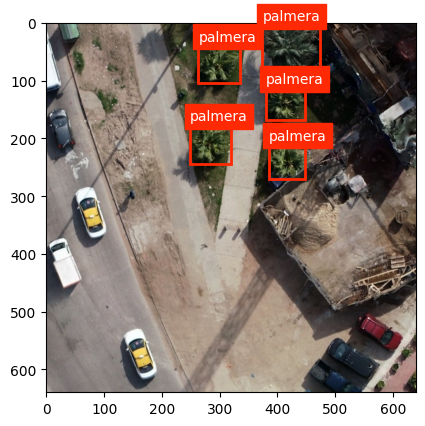

In [17]:
image_name = "8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm_crop_31"
image_path = DATASET_PROCESSED_PATH / "images" / "train" / f"{image_name}.jpg"
txt_path = DATASET_PROCESSED_PATH / "labels" / "train" / f"{image_name}.txt"

category_map = {cat["id"]: cat["name"] for cat in CATEGORIES}

visualize_image_annotations(image_path, txt_path, category_map)

#### Observamos el aumento de datos

train: Fast image access  (ping: 205.6119.8 ms, read: 2.32.2 MB/s, size: 181.3 KB)


train: Scanning E:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-IA\data\processed\coco_palm_dataset_v1.0_yolo\labels\train.cache... 9467 images, 4726 backgrounds, 0 corrupt: 100%|██████████| 9467/9467 [00:00<?, ?it/s]

train: E:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-IA\data\processed\coco_palm_dataset_v1.0_yolo\images\train\Rotonda_Arocena_20240927_dji_rtk_5cm_crop_313.jpg: 1 duplicate labels removed
train: E:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-IA\data\processed\coco_palm_dataset_v1.0_yolo\images\train\Rotonda_Arocena_20240927_dji_rtk_5cm_crop_345.jpg: 1 duplicate labels removed


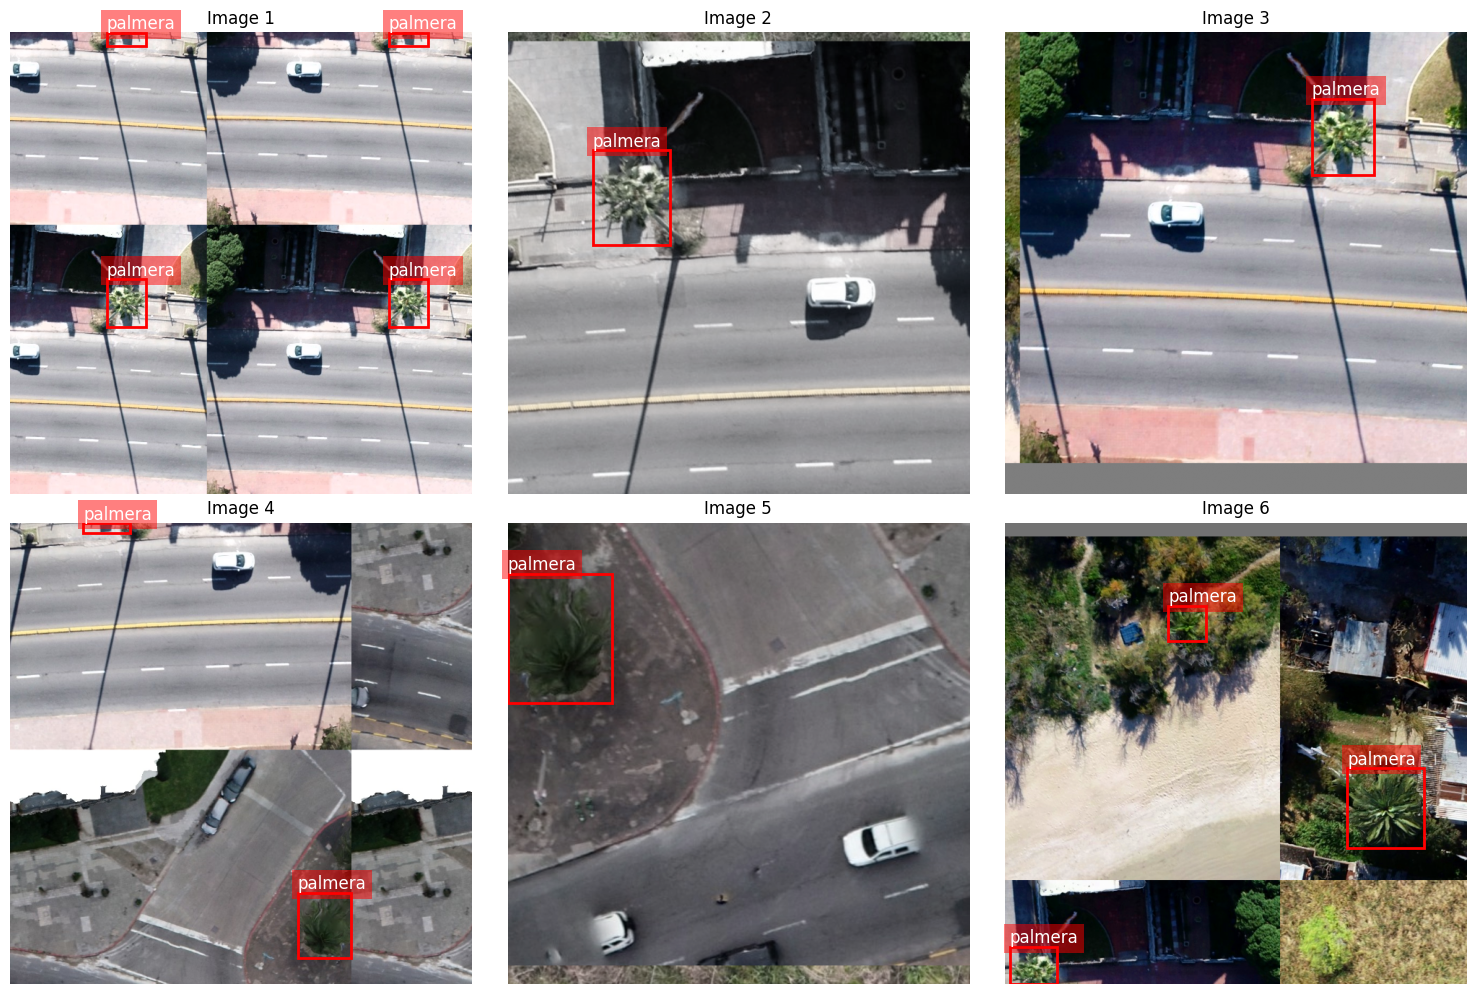

In [14]:
yolo_training_dataloader = YoloUtils.get_yolo_training_dataloader(
    cfg_path=AUMENTATIONS_CONFIG_FILE_PATH,
    cfg_data=DATASET_PROCESSED_PATH / "dataset.yaml",
    cfg_imgsz=IMG_SIZE,
    cfg_batch=6,
    dataset_path=DATASET_PROCESSED_PATH / "images" / "train",
)
YoloUtils.plot_yolo_augmentations(yolo_training_dataloader, CLASS_NAMES, max_batches=1)

## Entrenamiento del modelo

Creamos el modelo de detección de objetos YOLOv11:

<small><em>https://docs.ultralytics.com/modes/train/#train-settings</em></small>

In [15]:
if SHOULD_TRAIN:
    model = YOLO(MODEL_CHECKPOINT)
else:
    model = YOLO(Path(EXPERIMENT_NAME) / "train" / "weights" / "best.pt")

Imprimimos el modelo:

In [16]:
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

Mostramos información del modelo:

> 📝 <em><font color='Gray'>Nota:</font></em> $\text{Max batch size} = \frac{\text{Available GPU memory (bytes)}}{4 \times (\text{Size of tensors} + \text{Trainable parameters})}$


In [17]:
print(f"Información básica del modelo:")
model.info()

Información básica del modelo:
YOLO11n summary: 181 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(181, 2624080, 0, 6.614336)

Entrenamos el modelo:

- <small>https://docs.ultralytics.com/yolov5/tutorials/tips_for_best_training_results/#advanced-optimization-techniques</small>
- <small>https://docs.ultralytics.com/guides/yolo-data-augmentation/#introduction</small>

In [ ]:
if SHOULD_TRAIN:
    with mlflow.start_run():
        mlflow.set_experiment(EXPERIMENT_NAME)  # Establece el experimento de MLflow
        mlflow.log_param("dataset_name", DATASET_NAME)  # Registra el nombre del dataset
        mlflow.log_param("dataset_version", DATASET_VERSION)  # Registra la versión del dataset
        mlflow.log_param("dataset_format", DATASET_FINAL_FORMAT)  # Registra el formato del dataset
        mlflow.log_param("dataset_processed_name", DATASET_PROCESSED_NAME)  # Registra el nombre del dataset procesado
        mlflow.log_param("dataset_metrics", json.dumps(dataset_metrics))  # Registra las métricas del dataset como JSON
        mlflow.log_param(
            "transforms", ", ".join(CUSTOM_TRANSFORMS)
        )  # Registra las transformaciones aplicadas al dataset
        mlflow.log_param("model_name", MODEL_NAME)  # Registra el nombre del modelo
        mlflow.log_param("img_size", IMG_SIZE)  # Registra el tamaño de la imagen

        history = model.train(
            cfg=str(AUMENTATIONS_CONFIG_FILE_PATH),  # Configuración de aumentaciones
            data=str(DATASET_PROCESSED_PATH / "dataset.yaml"),
            epochs=N_EPOCHS,
            batch=BATCH_SIZE,
            device=0,  # Usa la GPU 0
            verbose=VERBOSE,  # Muestra época a época la evolución
            imgsz=IMG_SIZE,
            project=EXPERIMENT_NAME,
            # seed=CONFIG.seed,
            exist_ok=True,
            save_period=10,
            patience=10,
            # cache=True,
            plots=True,
        )

## Métricas de entrenamiento

In [48]:
try:
    results_df = pd.read_csv(history.save_dir / "results.csv").set_index("epoch")
    results_df["time_diff"] = results_df["time"].diff().fillna(0)
except FileNotFoundError:
    LOGGER.warning("No se encontró el archivo results.csv. Asegúrate de que el entrenamiento se completó correctamente.")
    results_df = pd.DataFrame()
except NameError:
    LOGGER.error("El entrenamiento no se realizó correctamente. Verifica los parámetros de entrenamiento.")
    results_df = pd.DataFrame()
except Exception as e:
    LOGGER.error(f"Error al cargar los resultados del entrenamiento: {e}")
    results_df = pd.DataFrame()
results_df

time  train/box_loss  train/cls_loss  train/dfl_loss  \
epoch                                                             
1       131.087         1.40651         2.90929         1.48349   
2       168.160         1.24879         1.50395         1.30456   
3       205.569         1.34671         1.32974         1.36347   
4       241.307         1.43192         1.32828         1.42619   
5       276.257         1.37411         1.20812         1.39468   
...         ...             ...             ...             ...   
196    7105.350         0.62874         0.36414         0.95737   
197    7139.970         0.62969         0.36458         0.95715   
198    7174.880         0.61873         0.35420         0.95552   
199    7209.640         0.61283         0.35660         0.95501   
200    7244.450         0.61573         0.35459         0.95627   

       metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
epoch                                                              
1                   0.80307            0.61165           0.68461   
2                   0.74890            0.58172           0.65044   
3                   0.56284            0.42961           0.43032   
4                   0.57406            0.46234           0.48098   
5                   0.81339            0.61893           0.69461   
...                     ...                ...               ...   
196                 0.91755            0.81038           0.87093   
197                 0.91732            0.81068           0.87116   
198                 0.91823            0.81068           0.87053   
199                 0.91922            0.81014           0.87041   
200                 0.92002            0.80968           0.87115   

       metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss  \
epoch                                                                  
1                  0.43668       1.22419       4.91172       1.42973   
2                  0.41749       1.31844       2.36205       1.42507   
3                  0.24012       1.68592      14.77640       1.83064   
4                  0.31046       1.36248      16.16690       1.49821   
5                  0.42979       1.37691       1.61091       1.55350   
...                    ...           ...           ...           ...   
196                0.68633       0.76321       0.42862       1.07353   
197                0.68642       0.76244       0.42886       1.07270   
198                0.68640       0.76198       0.42902       1.07180   
199                0.68612       0.76131       0.42853       1.07110   
200                0.68628       0.76114       0.42881       1.07063   

         lr/pg0    lr/pg1    lr/pg2  time_diff  
epoch                                           
1      0.003311  0.003311  0.003311      0.000  
2      0.006611  0.006611  0.006611     37.073  
3      0.009879  0.009879  0.009879     37.409  
4      0.009851  0.009851  0.009851     35.738  
5      0.009802  0.009802  0.009802     34.950  
...         ...       ...       ...        ...  
196    0.000347  0.000347  0.000347     34.870  
197    0.000298  0.000298  0.000298     34.620  
198    0.000249  0.000249  0.000249     34.910  
199    0.000199  0.000199  0.000199     34.760  
200    0.000150  0.000150  0.000150     34.810  

[200 rows x 15 columns]

## Validación del modelo

Cargamos el mejor modelo:

In [20]:
print(f"Nombre del proyecto: {EXPERIMENT_NAME}")
best_model_path = Path(EXPERIMENT_NAME) / "train" / "weights" / "best.pt"

if not best_model_path.exists():
    LOGGER.error(f"El modelo {best_model_path} no existe")
    sys.exit(1)
best_model = YOLO(best_model_path)

Nombre del proyecto: coco_palm_dataset_v1.0_palm_detection_yolo11n_640


Limpiamos la GPU:

In [21]:
GpuUtils.clean_gpu_usage()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 11% | 12% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 11% |  8% |


Validamos el modelo:

In [22]:
metrics = best_model.val(
    project=EXPERIMENT_NAME,
    data=str(DATASET_PROCESSED_PATH / "dataset.yaml"),
    split="test",
    exist_ok=True
)

Ultralytics 8.3.161  Python-3.13.3 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 8.81.8 MB/s, size: 161.0 KB)


val: Scanning E:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-IA\data\processed\coco_palm_dataset_v1.0_yolo\labels\test... 1184 images, 597 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:20<00:00, 58.75it/s] 

val: New cache created: E:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-IA\data\processed\coco_palm_dataset_v1.0_yolo\labels\test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:10<00:00,  6.77it/s]


                   all       1184       1174      0.915      0.798       0.86      0.688
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to coco_palm_dataset_v1.0_palm_detection_yolo11n_640\val


Imprimimos el reporte de validación:

In [23]:
metrics.summary()

[{'Class': 'palmera',
  'Images': np.int64(587),
  'Instances': np.int64(1174),
  'Box-P': np.float64(0.91501),
  'Box-R': np.float64(0.79782),
  'Box-F1': np.float64(0.85241),
  'mAP50': np.float64(0.85998),
  'mAP50-95': np.float64(0.68823)}]

## Predicción

Cargamos el modelo:

In [24]:
print(f"Nombre del proyecto: {EXPERIMENT_NAME}")
best_model_path = Path(EXPERIMENT_NAME) / "train" / "weights" / "best.pt"

if not best_model_path.exists():
    LOGGER.error(f"El modelo {best_model_path} no existe")
    sys.exit(1)

best_model = YOLO(best_model_path)

Nombre del proyecto: coco_palm_dataset_v1.0_palm_detection_yolo11n_640


Descargamos la imagen de prueba:

In [25]:
image_name = "barrioCanadaVictoria_20180801_dji_pc_3cm" # 319 Mb -> 5.47 min
# image_name = "BarrioCasabo_20240419_dji_pc_5cm" # 265 Mb -> 2.15 min
# image_name = "barrio3Ombues_20180801_dji_pc_3cm" # 190.4 Mb -> 3.32 min
# image_name = "Sayago_FFCC_20210319_dji_5c" # 143 Mb -> 1.44 min
# image_name = "BalconDelCerro_20240726_dji_rtk_5cm" # 100 Mb -> 50 s
# image_name = "PlayadelCerro_20221118_dji_pc_5cm" # 66 Mb -> 51 s
# image_name = "8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm"
Path(DOWNLOAD_PREDICTION_FOLDER).mkdir(parents=True, exist_ok=True)
image_file_path = DOWNLOAD_PREDICTION_FOLDER / f"{image_name}.jpg"
ProcesadorS3.download_images_from_minio([image_name], DOWNLOAD_PREDICTION_FOLDER)
LOGGER.debug(f"Se descargó la imagen {image_file_path} desde MinIO")

Descargando imágenes: 100%|██████████| 1/1 [00:14<00:00, 14.84s/MB]


### Predicción normal

Realizamos la predicción normal:

In [26]:
# result = best_model.predict(image_file_path)[0]

Obtenemos los resultados:

In [27]:
# xywh = result.boxes.xywh  # center-x, center-y, width, height
# xywhn = result.boxes.xywhn  # normalized
# xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
# xyxyn = result.boxes.xyxyn  # normalized
# names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
# confs = result.boxes.conf  # confidence score of each box

# print(f"Resultados para la imagen: {image_name}")
# print(f"Cantidad de detecciones: {len(names)}")
# if len(names) == 0:
#     print("No se detectaron objetos.")
# else:
#     for i, (name, conf, box) in enumerate(zip(names, confs, xyxy)):
#         print(f"Detección {i+1}: Clase={name}, Confianza={conf.item():.2f}, Caja={box.tolist()}")

Filtramos los resultados según la confianza:

In [28]:
# confidence_threshold = 0.50  # Ajusta según necesidad

# # Filtrar los índices según el umbral
# filtered_indices = [i for i, conf in enumerate(result.boxes.conf) if conf.item() >= confidence_threshold]

# # Filtrar las cajas y otros atributos
# filtered_boxes = result.boxes[filtered_indices]

# # Crear un nuevo objeto Results con las mismas propiedades pero solo con las detecciones filtradas
# results_filtered = Results(
#     orig_img=result.orig_img,
#     path=result.path,
#     names=result.names,
# )
# results_filtered.boxes = filtered_boxes
# results_filtered.orig_shape = result.orig_shape
# results_filtered.speed = result.speed
# results_filtered.save_dir = result.save_dir

Mostramos los resultados filtrados:

In [29]:
# xywh = results_filtered.boxes.xywh  # center-x, center-y, width, height
# xywhn = results_filtered.boxes.xywhn  # normalized
# xyxy = results_filtered.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
# xyxyn = results_filtered.boxes.xyxyn  # normalized
# names = [results_filtered.names[cls.item()] for cls in results_filtered.boxes.cls.int()]  # class name of each box
# confs = results_filtered.boxes.conf  # confidence score of each box

# print(f"Resultados para la imagen: {image_name}")
# print(f"Cantidad de detecciones: {len(names)}")
# if len(names) == 0:
#     print("No se detectaron objetos.")
# else:
#     for i, (name, conf, box) in enumerate(zip(names, confs, xyxy)):
#         print(f"Detección {i+1}: Clase={name}, Confianza={conf.item():.2f}, Caja={box.tolist()}")

### Predicción SAHI

In [30]:
model_predictor = DetectionModelPredictor(model=best_model, target_img_size_wh=[IMG_SIZE, IMG_SIZE])
predictions = model_predictor.predict(image_file_path)
result_df = predictions.as_pandas()


0: 640x640 (no detections), 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 17.5ms
Speed: 2.6ms preprocess, 17.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.6ms
Speed: 2.7ms preprocess, 12.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.8ms
Speed: 4.6ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 3.7ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 17.2ms
Speed: 2.5ms preprocess, 17.2ms inferen

Mostramos la imagen sin filtrar los resultados:

In [ ]:
annotated_image = predictions.get_annotated_image(cv2.imread(str(image_file_path)))
annotated_image_path = DOWNLOAD_PREDICTION_FOLDER / f"annotated_{image_file_path.name}_witout_filter.jpg"
cv2.imwrite(str(annotated_image_path), annotated_image)

Image.open(annotated_image_path).show()

Filtramos los resultados según la confianza:

In [ ]:
predictions = predictions.filter_by_confidence(min_confidence=0.9)

Mostramos la imagen filtrada:

In [33]:
annotated_image = predictions.get_annotated_image(cv2.imread(str(image_file_path)))
annotated_image_path = DOWNLOAD_PREDICTION_FOLDER / f"annotated_{image_file_path.name}"
cv2.imwrite(str(annotated_image_path), annotated_image)

Image.open(annotated_image_path).show()

Convertimos los resultados a anotaciones:

In [34]:
coco_annotations = predictions.as_coco_annotations(image_name, should_download=True)
print("Anotaciones COCO:")
pprint(coco_annotations)

2025-08-02 23:51:12.028 | SUCCESS  | modulo_apps.labeling.procesador_anotaciones_coco_dataset:create_coco_annotations_from_detections:316 - Anotaciones COCO guardadas en downloads\coco_annotations\coco_annotations.json


Anotaciones COCO:
{'annotations': [{'area': 110866.65112184733,
                  'attributes': {'occluded': False, 'rotation': 0.0},
                  'bbox': [6887.1939697265625,
                           26062.720275878906,
                           342.98077392578125,
                           323.2445068359375],
                  'category_id': 0,
                  'confidence': 0.916968153641463,
                  'id': 1,
                  'image_id': 1,
                  'iscrowd': 0},
                 {'area': 109720.42522877455,
                  'attributes': {'occluded': False, 'rotation': 0.0},
                  'bbox': [6714.474548339844,
                           39636.06915283203,
                           335.445556640625,
                           327.088623046875],
                  'category_id': 0,
                  'confidence': 0.9111188753091566,
                  'id': 2,
                  'image_id': 1,
                  'iscrowd': 0},
                 {

Visualizamos los resultados:

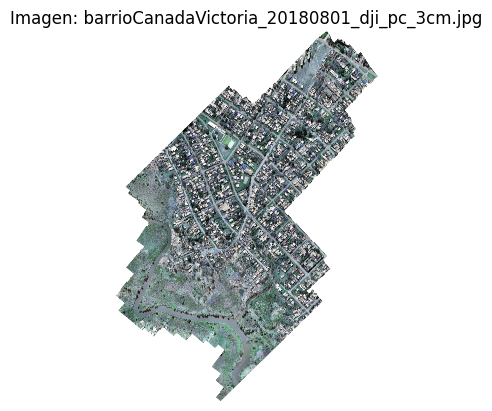

In [35]:
VisualizadorCocoDataset.show_anotated_image(image_path=image_file_path, coco_annotations=coco_annotations)

Mostramos los puntos:

In [36]:
predictions.as_pandas()

x1            y1            x2            y2  confidence  \
0    6887.193970  26062.720276   7230.174744  26385.964783    0.916968   
1    6714.474548  39636.069153   7049.920105  39963.157776    0.911119   
2   15017.393188  46316.488037  15310.549042  46637.457504    0.906393   
3    3275.933105  42211.405701   3593.473694  42512.971497    0.913873   
4   13809.415466  44577.530579  14150.516266  44892.429810    0.911101   
5   21315.729233  45852.565094  21640.897461  46164.230621    0.921504   
6    4913.553650  38869.089722   5244.815125  39176.955414    0.915923   
7    9080.271179  20650.769897   9415.626251  20992.075928    0.904624   
8    6321.107544  38388.815125   6638.745728  38704.105225    0.915182   
9    6065.977173  43067.709351   6333.180908  43346.270325    0.903455   
10  14941.820618  12066.589676  15269.425323  12401.289124    0.905921   
11   3814.866333  36689.587128   4113.485718  36988.229034    0.913402   
12   8832.000000  42469.981689   9078.846558  42879.751648    0.905163   
13  17176.377930  46665.745926  17447.593384  46939.690125    0.907794   
14  26157.702209  19706.720322  26497.509033  20003.483398    0.907184   
15   6065.185669  43068.904419   6333.488892  43346.259949    0.909156   
16  25534.818298  20291.045837  25863.883911  20619.388062    0.904966   
17  14015.045074  46961.516678  14298.831573  47254.969910    0.908889   
18   9216.000000  20736.244797   9415.248917  20987.834061    0.907763   
19  17845.983643  51739.707947  18150.257538  52030.409622    0.904818   
20  10586.566467  42958.178833  10949.888916  43306.524719    0.902119   
21   1297.793274  39346.945038   1634.077271  39669.516083    0.904112   
22  17520.070923  43018.886932  17858.324097  43324.932281    0.900697   

    class_id class_name  
0          0    palmera  
1          0    palmera  
2          0    palmera  
3          0    palmera  
4          0    palmera  
5          0    palmera  
6          0    palmera  
7          0    palmera  
8          0    palmera  
9          0    palmera  
10         0    palmera  
11         0    palmera  
12         0    palmera  
13         0    palmera  
14         0    palmera  
15         0    palmera  
16         0    palmera  
17         0    palmera  
18         0    palmera  
19         0    palmera  
20         0    palmera  
21         0    palmera  
22         0    palmera

#### Generar KML

In [37]:
jgw_data = ProcesadorAnotacionesMongoDB.load_jgw_file_from_mongodb(image_name=image_name, should_download=True)
pprint(jgw_data)

2025-08-02 23:51:49.102 | SUCCESS  | modulo_apps.labeling.procesador_anotaciones_mongodb:load_jgw_file_from_mongodb:676 - Archivo JGW guardado en downloads\jgw\jgw_data.json.


{'x_origin': 568674.5920415899,
 'x_pixel_size': 0.0260406,
 'x_rotation': 0.0,
 'y_origin': 6143155.189117069,
 'y_pixel_size': -0.0260406,
 'y_rotation': 0.0}


In [38]:
gdf = ProcesadorGeoJSONKML.create_geojson_from_annotations(image_name, coco_annotations, jgw_data, should_download=True)
gdf.head()

2025-08-02 23:51:51.865 | INFO     | modulo_apps.labeling.procesador_geojson_kml:create_geojson_from_annotations:294 - GeoJSON guardado en downloads\geojson\annotations.geojson


name  annotation_id        bbox_x        bbox_y  bbox_width  \
0  palmera-sana              1   6887.193970  26062.720276  342.980774   
1  palmera-sana              2   6714.474548  39636.069153  335.445557   
2  palmera-sana              3  15017.393188  46316.488037  293.155853   
3  palmera-sana              4   3275.933105  42211.405701  317.540588   
4  palmera-sana              5  13809.415466  44577.530579  341.100800   

   bbox_height    global_tl_x   global_tl_y    global_br_x   global_br_y  \
0   323.244507  568853.938705  6.142477e+06  568862.870130  6.142468e+06   
1   327.088623  568849.440988  6.142123e+06  568858.176191  6.142115e+06   
2   320.969467  569065.653971  6.141949e+06  569073.287925  6.141941e+06   
3   301.565796  568759.899305  6.142056e+06  568768.168253  6.142048e+06   
4   314.899231  569034.197506  6.141994e+06  569043.079975  6.141986e+06   

                      geometry  
0  POINT (-56.24671 -34.85776)  
1  POINT (-56.24673 -34.86094)  
2   POINT (-56.24436 -34.8625)  
3  POINT (-56.24771 -34.86155)  
4   POINT (-56.2447 -34.86209)

In [39]:
kml = ProcesadorGeoJSONKML.generate_kml_from_geojson(gdf, should_download=True)

2025-08-02 23:51:51.992 | INFO     | modulo_apps.labeling.procesador_geojson_kml:generate_kml_from_geojson:429 - Archivo KML guardado en downloads\kmls\palmeras.kml


In [40]:
# Test
kml_text = kml.to_string()
gdf_test = ProcesadorGeoJSONKML.convert_kml_to_geojson(kml_text)

2025-08-02 23:51:52.060 | SUCCESS  | modulo_apps.labeling.procesador_geojson_kml:convert_kml_to_geojson:120 - Conversión exitosa.
